In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import cemo_module as cemo

In [2]:
calls_df = pd.read_csv('data/Analysis/90degreeheatday.csv', 
                       usecols= ['District','date_time','heat_index_high', 'calls', 'calls_per_10000'], 
                       parse_dates=['date_time']
                       )

In [3]:
calls_df = calls_df[calls_df['date_time']<'2023-01-01']

In [4]:
def grouping(day):
    if day >= 2:
        return 'Heat Event'
    else:
        return 'Not a Heat Event'

In [5]:
thresholds = [90, 95, 100]
districts = calls_df['District'].unique()
df_list = []

#Calculate heat events across districts across thresholds
for district in districts:
    df = calls_df[calls_df['District']==district].copy()
    df.reset_index(drop=True, inplace=True)
    for threshold in thresholds:
        
        thresh = np.vectorize(cemo.heat_threshold)(df['heat_index_high'], threshold)
        streak = cemo.streak(pd.Series(thresh)).fillna(0)

        df[f'{threshold}_degree_event'] = streak >= 2
        
    df_list.append(df)

heat_events_df = pd.concat(df_list, ignore_index=True)

In [6]:
heat_events_df.groupby('District').sum()

<ipython-input-6-b9f8633f23c0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  heat_events_df.groupby('District').sum()


,heat_index_high,calls,calls_per_10000,90_degree_event,95_degree_event,100_degree_event
District,,,,,,
1,135661.023503,13277,3529.239766,43,15,3
2,135445.930131,19345,4112.107814,43,14,3
3,135339.129670,21475,5692.058948,39,13,3
4,135302.041357,29375,14117.844956,38,13,3
5,130202.738511,10113,3112.171103,14,3,0
...,...,...,...,...,...,...
106,138713.051552,11118,3787.171714,112,31,12
107,140424.582033,7528,4105.808563,178,41,17
108,136268.372323,850,1845.419019,59,19,6


In [7]:
heat_events_df[heat_events_df['100_degree_event']==True]

,District,date_time,heat_index_high,calls,calls_per_10000,90_degree_event,95_degree_event,100_degree_event
187,1,2018-07-07,102.418791,7,1.860712,True,True,True
1707,1,2022-09-04,106.630300,10,2.658161,True,True,True
1708,1,2022-09-05,102.531571,11,2.923977,True,True,True
2013,2,2018-07-07,102.274011,11,2.338237,True,True,True
3533,2,2022-09-04,106.471933,15,3.188504,True,True,True
...,...,...,...,...,...,...,...,...
184310,109,2022-09-07,100.156562,1,0.863856,True,True,True
184311,109,2022-09-08,100.144096,3,2.591569,True,True,True
184312,109,2022-09-09,102.196592,3,2.591569,True,True,True
186134,112,2022-09-05,101.046841,3,2.891566,True,True,True


In [8]:
series_list = []

for threshold in thresholds:
    col_name = f'{threshold}_degree_event'
    #get df with average and deviation of calls by district by heat day
    expected = heat_events_df.groupby(['District', col_name])['calls'].agg(['mean', 'std']).reset_index()
    #filter to non-heat days
    expected = expected[expected[col_name]==False]
    #buffer mean with standard deviation
    expected['expected'] = expected['mean'] + expected['std']
    #merge expected calls to call volume df
    call_calc = heat_events_df[['District', 'date_time', 'calls', col_name]].merge(expected[['District', 'expected']], on='District', how='left')
    #calculate difference between observed and expected calls and restrict lower bound to zero
    #multiply by the day type field to keep only rows where heat_day=true
    call_calc['excess'] = ((call_calc['calls'] - call_calc['expected']).clip(lower=0))*call_calc[col_name]
    #sum excess calls and create series
    s = call_calc.groupby('District')['excess'].sum().rename(f'{threshold}_excess')

    series_list.append(s)

results_df = pd.concat(series_list, axis=1)
results_df

,90_excess,95_excess,100_excess
District,,,
1,30.175231,12.967430,0.973294
2,45.741067,28.230483,0.974438
3,13.982710,10.531727,7.507632
4,32.192010,15.259558,2.229571
5,1.995439,1.002295,0.000000
...,...,...,...
106,35.265582,11.190588,4.719442
107,48.573001,12.540633,4.254722
108,7.875042,0.831176,0.833032


In [9]:
lcva_gdf = gpd.read_file('data/LCVA/LCVA_pop.gpkg')
lcva_gdf = lcva_gdf[['District', 'Population','geometry']]
lcva_gdf['District'] = lcva_gdf['District'].astype(int)
lcva_gdf.head()

,District,Population,geometry
0,58,50680.0,"MULTIPOLYGON (((-118.36743 34.06034, -118.3672..."
1,23,8631.0,"MULTIPOLYGON (((-118.53778 34.11104, -118.5766..."
2,47,35232.0,"MULTIPOLYGON (((-118.16056 34.08369, -118.1605..."
3,55,31968.0,"MULTIPOLYGON (((-118.23008 34.13561, -118.2304..."
4,62,55487.0,"MULTIPOLYGON (((-118.43229 34.02398, -118.4338..."


In [10]:
absolute_gdf = lcva_gdf.set_index('District').join(results_df)
absolute_gdf

,Population,geometry,90_excess,95_excess,100_excess
District,,,,,
58,50680.0,"MULTIPOLYGON (((-118.36743 34.06034, -118.3672...",5.202587,5.234008,4.119420
23,8631.0,"MULTIPOLYGON (((-118.53778 34.11104, -118.5766...",10.666807,7.447420,6.724672
47,35232.0,"MULTIPOLYGON (((-118.16056 34.08369, -118.1605...",29.535584,19.626760,4.400982
55,31968.0,"MULTIPOLYGON (((-118.23008 34.13561, -118.2304...",7.571668,1.974862,1.324351
62,55487.0,"MULTIPOLYGON (((-118.43229 34.02398, -118.4338...",12.760096,0.000000,0.000000
...,...,...,...,...,...
43,42596.0,"MULTIPOLYGON (((-118.40045 34.04014, -118.4004...",2.880959,0.000000,0.000000
40,638.0,"MULTIPOLYGON (((-118.24484 33.76312, -118.2452...",1.668081,0.402883,0.269864
92,25696.0,"MULTIPOLYGON (((-118.42316 34.06581, -118.4233...",7.960111,0.981789,0.000000


In [11]:
for threshold in thresholds:
    absolute_gdf[f'{threshold}per10k'] = (absolute_gdf[f'{threshold}_excess']/absolute_gdf['Population'])*10000

absolute_gdf

,Population,geometry,90_excess,95_excess,100_excess,90per10k,95per10k,100per10k
District,,,,,,,,
58,50680.0,"MULTIPOLYGON (((-118.36743 34.06034, -118.3672...",5.202587,5.234008,4.119420,1.026556,1.032756,0.812830
23,8631.0,"MULTIPOLYGON (((-118.53778 34.11104, -118.5766...",10.666807,7.447420,6.724672,12.358715,8.628687,7.791301
47,35232.0,"MULTIPOLYGON (((-118.16056 34.08369, -118.1605...",29.535584,19.626760,4.400982,8.383170,5.570720,1.249143
55,31968.0,"MULTIPOLYGON (((-118.23008 34.13561, -118.2304...",7.571668,1.974862,1.324351,2.368515,0.617762,0.414274
62,55487.0,"MULTIPOLYGON (((-118.43229 34.02398, -118.4338...",12.760096,0.000000,0.000000,2.299655,0.000000,0.000000
...,...,...,...,...,...,...,...,...
43,42596.0,"MULTIPOLYGON (((-118.40045 34.04014, -118.4004...",2.880959,0.000000,0.000000,0.676345,0.000000,0.000000
40,638.0,"MULTIPOLYGON (((-118.24484 33.76312, -118.2452...",1.668081,0.402883,0.269864,26.145470,6.314779,4.229848
92,25696.0,"MULTIPOLYGON (((-118.42316 34.06581, -118.4233...",7.960111,0.981789,0.000000,3.097801,0.382079,0.000000


In [91]:
absolute_gdf.reset_index().to_file('data/Analysis/excess_calls.gpkg', driver='GPKG')

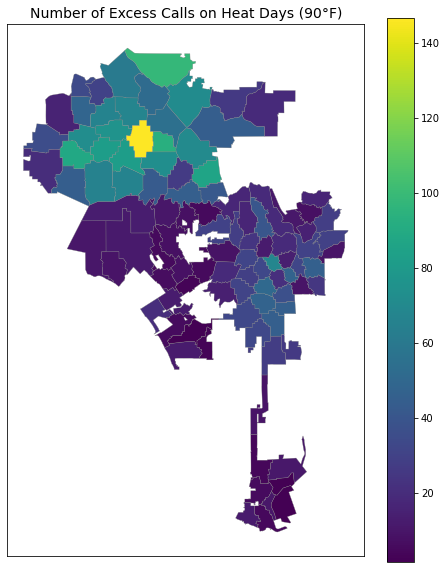

In [114]:
fig, ax = plt.subplots(figsize=(8, 10))
absolute_gdf.plot(column='90_excess', legend=True, edgecolor="grey", linewidth=0.3, ax=ax)

plt.xticks([])
plt.yticks([])

plt.title('Number of Excess Calls on Heat Days (90°F)', fontsize='14')
plt.show()


In [13]:
results_df.sum()

90_excess     3290.843834
95_excess     1196.959011
100_excess     388.810628
dtype: float64

In [8]:
calls_df['calls'].sum()

1679415